In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error
import seaborn as sns

In [76]:
X_train =np.load('X_train.npy')
Y_train =np.load('y_train.npy')
X_test =np.load('X_test.npy')

In [101]:
train_features = ['Air Temperature','Water Temperature','Wind speed','Wind Direction','Illumination']
scaler = StandardScaler()
X_train_norm = pd.DataFrame(scaler.fit_transform(X_train))
X_train_norm = X_train_norm.rename(columns={i:train_features[i] for i in range(5)})
y_train_df = pd.DataFrame(Y_train)
y_train_df.rename(columns={0:'y_train'}, inplace=True)
train_data = X_train_norm.copy()
train_data['Y_train'] = y_train_df.reset_index(drop=True)
train_data

,Air Temperature,Water Temperature,Wind speed,Wind Direction,Illumination,Y_train
0,0.381247,2.062005,0.378296,-0.393807,1.912646,-2.737384
1,-0.649277,-0.818513,2.165169,0.204288,-1.004879,-0.410969
2,-1.030509,-0.806199,-0.143433,-0.002829,-1.177856,14.833533
3,-1.930055,-0.942637,-1.331726,-0.966561,-1.733425,3.960804
4,0.939597,0.603392,-2.257478,-1.753702,0.944511,10.400393
...,...,...,...,...,...,...
195,0.377893,1.377785,0.457462,2.182375,1.451819,-2.356786
196,-0.240140,0.336880,-0.289301,1.212552,0.294484,-0.679252
197,1.040903,0.378041,-0.261347,-0.551529,0.842015,-2.202706
198,0.335330,0.772736,-0.675532,0.118341,0.806821,9.637862


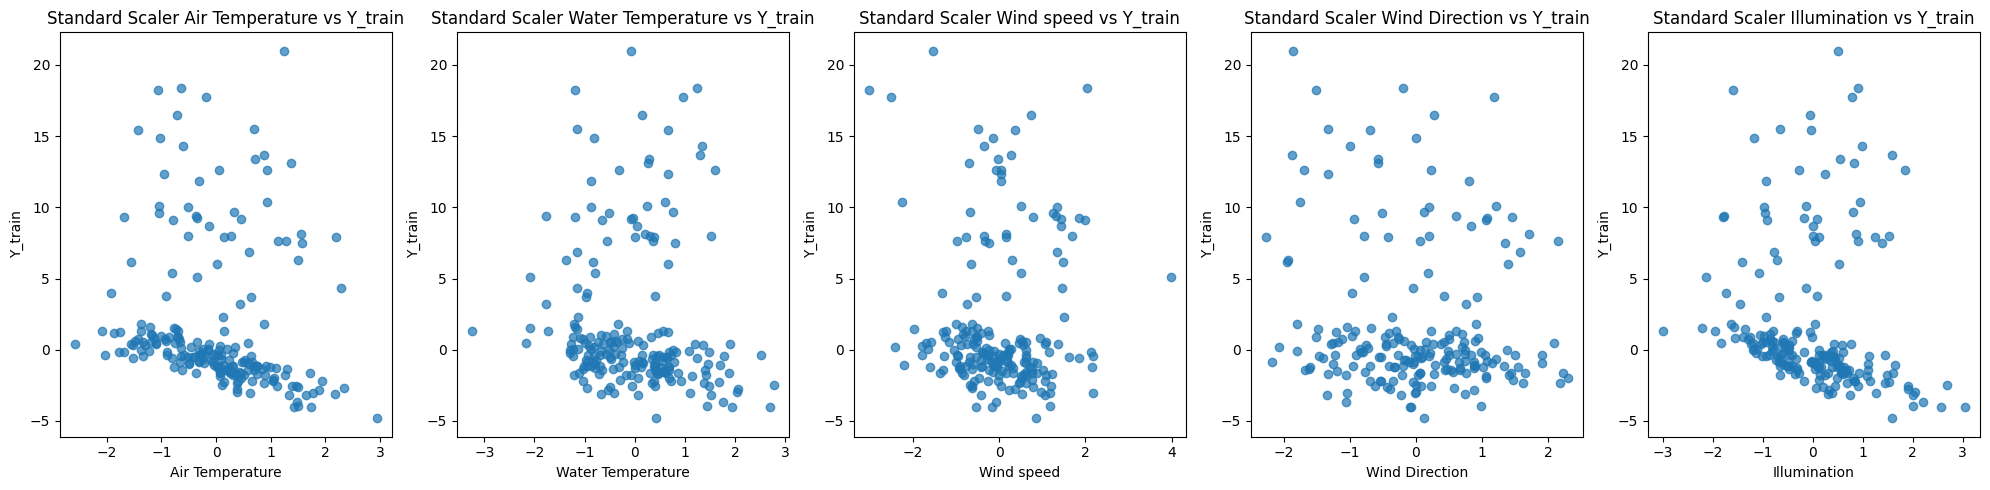

In [102]:
fig, axes = plt.subplots(1, 5, figsize=(20, 5))

for i, feature in enumerate(train_features):
    axes[i].scatter(X_train_norm[feature], Y_train, alpha=0.7)
    axes[i].set_title(f'Standard Scaler {feature} vs Y_train')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Y_train')

plt.tight_layout() 
plt.show()

In [111]:
train_data_filtered = train_data[(train_data['Y_train'] <= 3.5) & (train_data['Y_train'] >= -3.5)]
lr = LinearRegression()
lr.fit(train_data_filtered[train_features], train_data_filtered['Y_train'])
y_pred = lr.predict(X_train_norm)
print(lr.coef_)
alphas = [.0001, .0005, .001, 0.005, .01, 0.05, .1, .5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10] 
mses_r = [] 
for i in alphas:
    r = Ridge(alpha=i)
    r.fit(train_data_filtered[train_features], train_data_filtered['Y_train'])
    y_pred = r.predict(train_data_filtered[train_features])
    mses_r.append(mean_squared_error(train_data_filtered['Y_train'], y_pred))
    print(f'Alpha: {i}, Coefficients: {r.coef_}, MSE: {mean_squared_error(train_data_filtered["Y_train"], y_pred)}')
mses_l = [] 
for i in alphas:
    l = Lasso(alpha=i)
    l.fit(train_data_filtered[train_features], train_data_filtered['Y_train'])
    y_pred = l.predict(train_data_filtered[train_features])
    mses_l.append(mean_squared_error(train_data_filtered['Y_train'], y_pred))
    print(f'Alpha: {i}, Coefficients: {l.coef_}, MSE: {mean_squared_error(train_data_filtered["Y_train"], y_pred)}')



SyntaxError: f-string: unmatched '[' (3345028441.py, line 20)